# Exercise 06 CNN for Image Classification - Instruction

## Pedagogy

This notebook serves as an instruction for implementing CNNs using PyTorch to develop image classification models.

Please use this notebook as a reference and guide to complete the assignment.

### Pre-configure

In this notebook we will use several new libraries:
- `trochvision.datasets` for obtaining PyTorch built-in datasets
- `torchvision.transforms` for data preprocessing using PyTorch built-in transform functions
- `torch.utils.data.random_split` for splitting datasets like `sklearn.model_selection.train_test_split`

In [1]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Part 1. Hand-written Digits Recognition with <span style="color:red">**ANN**</span>

In this part, we will first build a multi-class image classifier using <span style="color:red">**ANN**</span> for comparison.

The problem to be solved is to recognize the hand-written digits:

![](https://upload.wikimedia.org/wikipedia/commons/b/b1/MNIST_dataset_example.png)

We will use the [PyTorch built-in MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) (70,000 samples).
- Each hand-written digit image contains $28\times28$ pixels with only one channel (grayscale image).
- There are 10 classes, where each class refers to one digit.
- Feature scaling has already been done in the pre-processing step, no need to perform feature scaling by ourselves.

We will first use this small dataset to illustrate how to implement a CNN. Then we will move to a large dataset (70,000 samples) in the next part.

We will first build an image classifier using traditional <span style="color:red">**ANN**</span>. In Part 2, we will build another image classifier using <span style="color:red">**CNN**</span> for comparison.

### Step 1. Build the data pipeline

In this step, we need to:
- Use `torchvision.datasets.MNIST()` to load the MNIST hand-written digits dataset
- Use `torchvision.transforms.ToTensor()` to convert the data to tensors
- The MNIST dataset is already divided into the training set and test set
- Use `torch.utils.data.random_split()` to further split the training set into the training set and validation set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [4]:
# load MNIST dataset
train_val_ds = datasets.MNIST(
    root = 'data', # root directory for storing data
    train = True, # get the train part
    download = True,
    transform = transforms.ToTensor() # convert to tensor
)
test_ds = datasets.MNIST(
    root = 'data', # root directory for storing data
    train = False, # get the test part
    download = True,
    transform = transforms.ToTensor() # convert to tensor
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2] # [train size, val size]
)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
# create data loaders
batch_size = 8192 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [6]:
# display the dimensionality of a batch
for (X, y) in val_dl:
    print('Feature shape:', X.shape)
    print('Label shape:', y.shape)
    break

Feature shape: torch.Size([8192, 1, 28, 28])
Label shape: torch.Size([8192])


We can see that given a batch of samples, the feature tensor has 4 dimensions:
- 1st dimension: the batch size, `8192` samples per batch
- 2nd dimension: the number of channels, `1` indicates one channel (grascale image)
- 3rd dimension: the height of input image
- 4th dimension: the width of input image

The label tensor has only 1 dimension, which is the batch size.

We can also display one example to check what it looks like.

The label of this hand-written digit is: 7


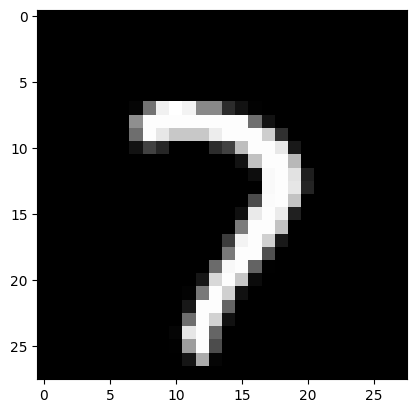

In [10]:
# display an example
plt.imshow(train_ds[0][0].numpy().reshape(28, 28), cmap = 'gray')
print('The label of this hand-written digit is:', train_ds[0][1])

### Step 2. Create an image classifier using <span style="color:red">**ANN**</span>

In this step, we will first create a class that inherits from `torch.nn.Module` to determine the network structure, the activation functions, and the forward method. And then initialize the neural network.

To use ANN for image processing, we typically add a `nn.Flatten()` layer in the network as the first layer. This is because:
- The shape of the input tensor of the network is `(batch_size, num_of_channels, height, width)`
- The `nn.Linear()` layer requires the input tensor of shape `(batch_size, num_of_features)`
- `nn.Flatten()` will reshape the input tensor as required by the `nn.Linear()` layer

We also include batch normalization layers and dropout layers for regularization purposes.

In [11]:
# define a custom neural network class
class ANNImageClassifier(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(), # reshape the input tensor
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128), # batch normalization
            nn.ReLU(),
            nn.Dropout(p = 0.5), # dropout with 50% probability
            nn.Linear(128, 64),
            nn.BatchNorm1d(64), # batch normalization
            nn.ReLU(),
            nn.Dropout(p = 0.5), # dropout with 50% probability
            nn.Linear(64, 16),
            nn.BatchNorm1d(16), # batch normalization
            nn.ReLU(),
            nn.Dropout(p = 0.5), # dropout with 50% probability
            nn.Linear(16, n_labels)
        )
    def forward(self, X):
        return self.net(X)

In [12]:
# initialize the model
ann_model = ANNImageClassifier(
    n_features = 784, # 1*28*28=784
    n_labels = 10 # 10 classes
)
ann_model.to(device)

ANNImageClassifier(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=16, out_features=10, bias=True)
  )
)

### Step 3. Train the network

In this step, we will define a `train()` function to perform the training process.

We implement weight decay, learning rate decay, early stopping, automatic model saving for regularization purposes.

We also add the time consumed information to the printed log.

In [13]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now() # record start time
    
    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train() # set the model in training mode
        for (X, y) in train_dl:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)
        
        # validation set
        val_epoch_loss = 0.0
        model.eval() # set the model in evaluation mode
        with torch.no_grad():
            for (X, y) in val_dl:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0] # calculate consumed time after completing one epoch
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")
        
        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')
            
        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            patience_counter = 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

After defining the `train()` function, we also need to specify the hyper-parameters for the training process:
- Loss function: use cross entropy loss for multi-class problems
- Initial learning rate
- Lamda for L2 norm regularization
- Optimizer: mini-batch gradient descent
    - We need to specify the model parameters we want to optimize
- Maximum number of epochs to train
- Early stopping patience
- Learning rate scheduler: reduce learning rate by monitoring validation loss
- Prefix of the saved file name

In [14]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    ann_model.parameters(), # specify which model to optimize
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)
saved_path_prefix = 'ann_image_classifier'

Then we can start the training process.

Be sure to pass the correct model to the `train()` function by correctly specifying the name of the model you want to train.

In [15]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    ann_model, # specify which model to train
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Epoch 1: train loss = 2.300082, val loss = 2.280718, time consumed = 0:00:04
Model saved after epoch 1

Epoch 2: train loss = 2.101022, val loss = 2.216218, time consumed = 0:00:05
Model saved after epoch 2

Epoch 3: train loss = 1.987458, val loss = 2.105470, time consumed = 0:00:06
Model saved after epoch 3

Epoch 4: train loss = 1.895298, val loss = 1.960505, time consumed = 0:00:07
Model saved after epoch 4

Epoch 5: train loss = 1.816310, val loss = 1.796935, time consumed = 0:00:08
Model saved after epoch 5

Epoch 6: train loss = 1.746679, val loss = 1.638587, time consumed = 0:00:09
Model saved after epoch 6

Epoch 7: train loss = 1.688592, val loss = 1.499062, time consumed = 0:00:10
Model saved after epoch 7

Epoch 8: train loss = 1.632211, val loss = 1.386479, time consumed = 0:00:12
Model saved after epoch 8

Epoch 9: train loss = 1.578464, val loss = 1.293836, time consumed = 0:00:13
Model saved after epoch 9

Epoch 10: train loss = 1.536326, val loss = 1.221854, time consu

We can see the training process took more than 5 minutes on my laptop.

It will take about 30 minutes on Google Colab.

It's much longer than the previous exercises we did.

One reason is that the data set is already big (70,000 samples).

Another reason is that the ANN is already complex.

We can calculate the number of learning parameters of the model to check the complexity of the ANN.

In [16]:
# get the number of learning parameters
num_learning_params = sum(p.numel() for p in ann_model.parameters() if p.requires_grad)
print(f"Number of learning parameters: {num_learning_params}")

Number of learning parameters: 110362


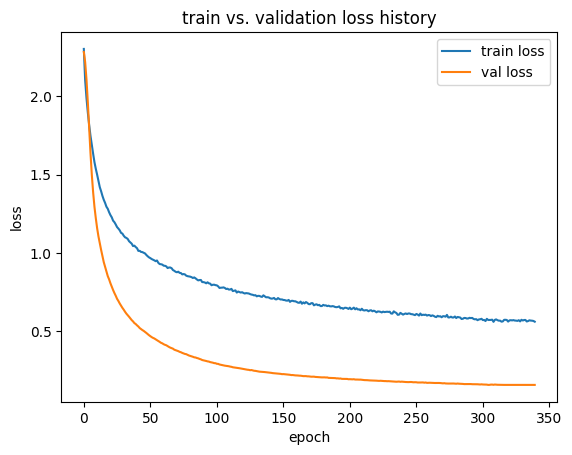

In [17]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

By visualizing the changes in the training loss and the validation loss during the training process, we can see that both losses are successfully reduced.

Since the training process was stopped when the validation loss stopped improving, we prevent the model from over-fitting.

### Step 4. Reload the best model

The final model after training may not be the best one saved during the training process.

To use the best model, we need to reload it from the saved file.

In [18]:
# load model
ann_model = ANNImageClassifier(
    n_features = 784,
    n_labels = 10
)
ann_model.load_state_dict(torch.load(saved_path))
ann_model.to(device)

ANNImageClassifier(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=16, out_features=10, bias=True)
  )
)

### Step 5. Evaluation using test set

In this step, we define a `test()` function to use the trained network to make predictions on the test set.

Then the predictions are used to calculate evaluation metrics for assessing the generalizability.

In [19]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_logits_list = []
    batch_prob_list = []
    batch_pred_list = []
    model.eval()
    with torch.no_grad():
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()
            batch_prob = torch.softmax(batch_logits, dim = -1)
            _, batch_pred = torch.max(batch_logits, 1)
            batch_logits_list.append(batch_logits.cpu().numpy())
            batch_prob_list.append(batch_prob.cpu().numpy())
            batch_pred_list.append(batch_pred.cpu().numpy())
        loss /= len(dataloader)
        logits = np.concatenate(batch_logits_list)
        prob = np.concatenate(batch_prob_list)
        pred = np.concatenate(batch_pred_list)
        print(f"test loss = {loss}")
    return logits, prob, pred, loss

In [20]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, ann_model, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred))

test loss = 0.12772896885871887
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.96      0.97      0.97       958
           7       0.96      0.95      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



The recognized digit is: 7
The predicted probability is: 0.992025


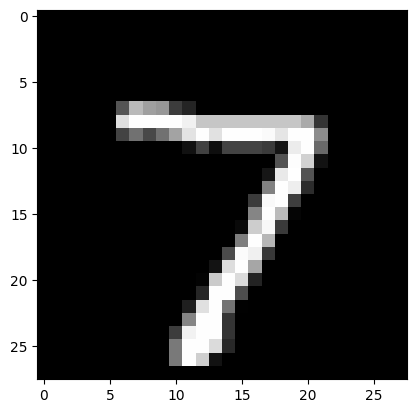

In [28]:
# display an example
plt.imshow(test_ds[0][0].numpy().reshape(28, 28), cmap = 'gray')
print('The recognized digit is:', test_pred[0])
print('The predicted probability is:', test_prob[0, test_pred[0]])

From the evaluation results, we can see that the performance of the ANN-based image classifier is very good.

The F1-scores of all digits are close to 1.

For the displayed example, the predicted probability is also close to 1.

However, the ANN is already complex (110,362 learning parameters) and the training process is already time-consuming.

The digit image has only $28\times28$ pixels and only one channel.

If we want to use ANN to process a 4K resolution image, the number of learning parameters will explode. And the training process will be too time-consuming and infeasible.

## Part 2. Hand-written Digits Recognition with <span style="color:red">**CNN**</span>

Now let's try to build a CNN-based image classifier for the same problem.

Let's compare the difference between ANN and CNN in terms of:
- The number of learning parameters
- Time consumed in the training process
- The performance of the trained model

### Step 1. Build the data pipeline

Let's use the same data pipeline.

### Step 2. Create an image classifier using <span style="color:red">**CNN**</span>

In this step, we will first create a class that inherits from `torch.nn.Module` to determine the network structure, the activation functions, and the forward method. And then initialize the neural network.

We will define a multi-layer CNN with 3 convolutional layers and 3 fully connected layers.
- Use `nn.Lazy...` to avoid calculating the input size yourself:
    - Use `nn.LazyConv2d` instead of `nn.Conv2d`
    - Use `nn.LazyBatchNorm2d` instead of `nn.BatchNorm2d`
    - Use `nn.LazyLinear` instead of `nn.Linear`
- Batch normalization layer is positioned before the activation function layer
- Pooling layer is positioned after the activation function layer
- Use `nn.Flatten` to flatten the 2D feature map into 1D feature vector
- Dropout layer is positioned after the activation function layer and only for fully connected layers
    - You can also add `nn.Dropout2d` between convolutional layers, which will randomly drop out the entire channel of the input feature map

In [29]:
# define a custom neural network class
class CNNImageClassifier(nn.Module):
    def __init__(self, in_channels, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 9, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 27, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
            nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
            nn.LazyLinear(10)
        )

    def forward(self, x):
        return self.net(x)

In [30]:
# initialize the neural network
cnn_model = CNNImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
)
cnn_model.to(device)

CNNImageClassifier(
  (net): Sequential(
    (0): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LazyConv2d(0, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): LazyConv2d(0, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): LazyLinear(in_features=0, out_features=100, bias=True)
    (14): LazyBatchNorm1d(0, eps=1e-05, m

### Step 3. Train the network

We will use the same `train()` function and the same training hyper-parameters for comparison.

Since we are going to train a different model, we need to create another optimizer for the cnn model.

In [31]:
# create a new optimizer for cnn
optimizer = torch.optim.SGD(
    cnn_model.parameters(), # specify which model to optimize
    lr = learning_rate,
    weight_decay = weight_decay
)

# create a new LR scheduler for the new optimizer
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)

# set another prefix
saved_path_prefix = 'cnn_image_classifier'

We also need to pass the correct network to the `train()` function.

In [32]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    cnn_model, # specify which model to train
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Epoch 1: train loss = 1.976297, val loss = 2.288629, time consumed = 0:00:04
Model saved after epoch 1

Epoch 2: train loss = 1.333094, val loss = 2.262380, time consumed = 0:00:06
Model saved after epoch 2

Epoch 3: train loss = 1.017969, val loss = 2.128242, time consumed = 0:00:07
Model saved after epoch 3

Epoch 4: train loss = 0.813642, val loss = 1.796007, time consumed = 0:00:09
Model saved after epoch 4

Epoch 5: train loss = 0.678032, val loss = 1.284070, time consumed = 0:00:11
Model saved after epoch 5

Epoch 6: train loss = 0.587320, val loss = 0.821578, time consumed = 0:00:12
Model saved after epoch 6

Epoch 7: train loss = 0.517993, val loss = 0.549031, time consumed = 0:00:14
Model saved after epoch 7

Epoch 8: train loss = 0.466347, val loss = 0.414805, time consumed = 0:00:16
Model saved after epoch 8

Epoch 9: train loss = 0.426684, val loss = 0.336657, time consumed = 0:00:17
Model saved after epoch 9

Epoch 10: train loss = 0.392771, val loss = 0.293671, time consu

We can see that we achieve a much lower validation loss with fewer epochs.

We can also calculate the number of learning parameters of the CNN.

In [33]:
# get the number of learning parameters
num_learning_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"Number of learning parameters: {num_learning_params}")

Number of learning parameters: 28184


We can see that the CNN has fewer learning parameters than the previous ANN (110,362 learning parameters).

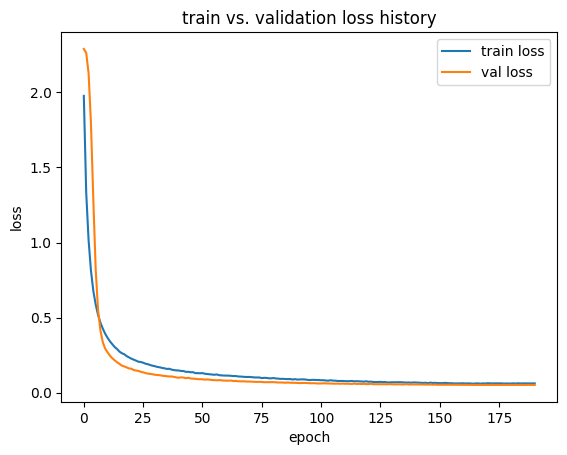

In [34]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Reload the best model

In [35]:
# reload model
cnn_model = CNNImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
)
cnn_model.load_state_dict(torch.load(saved_path))
cnn_model.to(device)

CNNImageClassifier(
  (net): Sequential(
    (0): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LazyConv2d(0, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): LazyConv2d(0, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): LazyLinear(in_features=0, out_features=100, bias=True)
    (14): LazyBatchNorm1d(0, eps=1e-05, m

### Step 5. Evaluation using test set

In [36]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, cnn_model, loss_fn)

# calculate classification report
print(classification_report(test_label, test_pred))

test loss = 0.03934888541698456
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



The recognized digit is: 7
The predicted probability is: 0.9997688


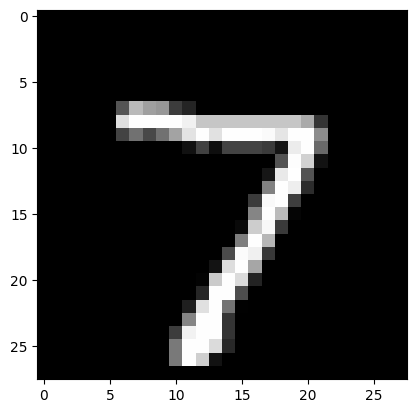

In [37]:
# display an example
plt.imshow(test_ds[0][0].numpy().reshape(28, 28), cmap = 'gray')
print('The recognized digit is:', test_pred[0])
print('The predicted probability is:', test_prob[0, test_pred[0]])

By comparing the evaluation results of CNN with the ones of ANN, we can find that CNN used fewer learning parameters and fewer training epochs but achieved a better performance.

That's why we typically use CNN instead of ANN for image processing.

The CNN architecture is designed to mimic human vision, thus more suitable for data modalities such as images and videos.